In [ ]:
import numpy as np
np.set_printoptions(precision=2, suppress=True)

# Solutions

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Circle

class RobotFollowerSimulation:
    def __init__(self):
      # Simulation Parameters
      self.dt = 0.1
      self.total_time = 60
      self.steps = int(self.total_time / self.dt)
      self.desired_distance = 2.0  # desired distance d from object

      # Object Motion Parameters
      self.object_speed = 1.89  # m/s
      self.object_angular_velocity = 0.1  # rad/s

      # Robot Motion Parameters
      self.max_linear_velocity = 1.5
      self.max_angular_velocity = np.pi / 4

      # Particle Filter Parameters
      self.num_particles = 1000
      self.particle_pos_variance = 1.0  # initial position variance
      self.particle_theta_variance = 0.1  # initial heading variance

      # Noise Parameters
      self.measurement_noise_std = 0.5  # standard deviation of measurement noise
      self.process_noise_std_pos = 0.1  # process noise for position
      self.process_noise_std_theta = 0.05  # process noise for heading

      # Initial Object State
      self.object_state = np.array([0.0, 0.0, 0.0])

      # Initial Robot State
      self.robot_state = np.array([-1.0, 0.0, 0.0])

      # Initial Particles (object position and heading estimates)
      self.particles = np.random.multivariate_normal(
          mean=[self.object_state[0], self.object_state[1], self.object_state[2]],
          cov=[
              [self.particle_pos_variance, 0, 0],
              [0, self.particle_pos_variance, 0],
              [0, 0, self.particle_theta_variance]
          ],
          size=self.num_particles
      )
      self.particles[:, 2] = self.wrap_angle(self.particles[:, 2])

      self.object_trajectory = []
      self.robot_trajectory = []
      self.est_mean_history = []
      self.est_cov_history = []

    @staticmethod
    def wrap_angle(theta):
      """
      Wrap angle to [-pi, pi]
      """
      return (theta + np.pi) % (2 * np.pi) - np.pi

    def motion_model(self, state, v, w):
      """
      Update robot state based on control inputs
      """
      x, y, theta = state
      x += v * np.cos(theta) * self.dt
      y += v * np.sin(theta) * self.dt
      theta += w * self.dt
      theta = self.wrap_angle(theta)
      new_state = np.array([x, y, theta])
      return new_state

    def object_motion(self, state):
      """
      Object motion in circular path with noise
      """
      x, y, theta = state
      x += self.object_speed * np.cos(theta) * self.dt
      y += self.object_speed * np.sin(theta) * self.dt
      theta += self.object_angular_velocity * self.dt
      theta = self.wrap_angle(theta)
      new_state = np.array([x, y, theta])
      return new_state

    def measurement_model(self, object_true_pos):
      """
      Noisy measurement of object position
      """
      measurement = object_true_pos[:2] + np.random.normal(0, self.measurement_noise_std, size=2)
      return measurement

    def particle_filter_update(self, particles, measurement):
      """
      Perform weight normalization in particle filter and resample

      Inputs:
        - particles: (x, y, theta) particles -- [np.ndarray: (self.num_particles, 3)]
        - measurement: (x, y) at timestep -- [np.ndarray: (2, )]

      Outputs:
        - resampled_particles: (x, y, theta) resampled partickes -- [np.ndarray: (self.num_particles, 3)]
      """
      #### Task 2.1: CODE STARTS HERE ####
      # Compute weights based on measurement likelihood (only x and y)
      distances = np.linalg.norm(particles[:, :2] - measurement, axis=1)
      weights = np.exp(-0.5 * (distances / self.measurement_noise_std) ** 2)
      weights += 1.e-300  # avoid zeros
      weights /= np.sum(weights)

      # Resample particles based on weights
      indices = np.random.choice(np.arange(self.num_particles), size=self.num_particles, p=weights)
      resampled_particles = particles[indices]

      # Add process noise to particles
      resampled_particles[:, 0] += np.random.normal(0, self.process_noise_std_pos, size=self.num_particles)
      resampled_particles[:, 1] += np.random.normal(0, self.process_noise_std_pos, size=self.num_particles)
      resampled_particles[:, 2] += np.random.normal(0, self.process_noise_std_theta, size=self.num_particles)
      resampled_particles[:, 2] = self.wrap_angle(resampled_particles[:, 2])
      #### Task 2.1: CODE ENDS HERE ####
      return resampled_particles

    def estimate_state(self, particles):
      """
      Estimate mean and covariance from particles

      Inputs:
        - particles: (x, y, theta) particles -- [np.ndarray: (self.num_particles, 3)]

      Outputs:
        - mean: (x, y, theta) estimated mean of particles -- [np.ndarray: (3, )]
        - cov_xy: (x, y) position covariance matrix -- [np.ndarray: (2, 2)]
      """
      #### Task 2.2: CODE STARTS HERE ####
      mean_x = np.mean(particles[:, 0])
      mean_y = np.mean(particles[:, 1])

      def circular_mean(angles):
          """Compute the circular mean of angles."""
          sin_sum = np.mean(np.sin(angles))
          cos_sum = np.mean(np.cos(angles))
          return self.wrap_angle(np.arctan2(sin_sum, cos_sum))

      mean_theta = circular_mean(particles[:, 2])
      mean = np.array([mean_x, mean_y, mean_theta])

      # Compute covariance for x and y
      cov_xy = np.cov(particles[:, :2], rowvar=False)
      #### Task 2.2: CODE ENDS HERE ####
      return mean, cov_xy

    def compute_control(self, robot_state, est_mean, est_cov):
      """
      Compute control inputs (v, w) based on estimated object position

      Inputs:
        - robot_state: (x, y, theta) state -- [np.ndarray: (3, )]

      Outputs:
        - v: linear velocity control -- [np.float64 / float]
        - w: angular velocity control -- [np.float64 / float]
        - (desired_x, desired_y): tuple of desired (x, y) states -- [np.float64 / float, np.float64 / float]
      """
      robot_x, robot_y, robot_theta = robot_state
      obj_x, obj_y, obj_theta = est_mean

      #### Task 2.3: CODE STARTS HERE ####
      # Desired position is d meters behind the object based on its heading
      # Note: Refer the diagram in the question
      desired_x = obj_x - self.desired_distance * np.cos(obj_theta)
      desired_y = obj_y - self.desired_distance * np.sin(obj_theta)

      # Compute the angle to the desired position
      dx = desired_x - robot_x
      dy = desired_y - robot_y
      desired_theta = np.arctan2(dy, dx)
      #### Task 2.3: CODE ENDS HERE ####

      # Compute control errors
      angle_error = self.wrap_angle(desired_theta - robot_theta)
      distance = np.hypot(dx, dy)

      # Control law
      K_v = 1.0
      K_w = 2.0
      v = K_v * distance
      w = K_w * angle_error

      #### Task 2.3: CODE STARTS HERE ####
      # Limit/ Clip velocities
      v = np.clip(v, -self.max_linear_velocity, self.max_linear_velocity)
      w = np.clip(w, -self.max_angular_velocity, self.max_angular_velocity)
      #### Task 2.3: CODE ENDS HERE ####
      return v, w, (desired_x, desired_y)

    def run_simulation(self):
      """
      Run the simulation loop

      Inputs:
      - N/A

      Outputs:
      - N/A
      """
      for step in range(self.steps):
        #### Task 2.4: CODE STARTS HERE ####
          # 1. Move the object
          self.object_state = self.object_motion(self.object_state)

          # 2. Simulate measurement
          measurement = self.measurement_model(self.object_state)

          # 3. Update Particle Filter
          self.particles = self.particle_filter_update(self.particles, measurement)

          # 4. Estimate object state
          est_mean, est_cov = self.estimate_state(self.particles)

          # 5. Compute control inputs
          v, w, desired_pos = self.compute_control(self.robot_state, est_mean, est_cov)

          # 6. Move the robot
          self.robot_state = self.motion_model(self.robot_state, v, w)
          #### Task 2.4: CODE ENDS HERE ####

          # Save
          self.est_mean_history.append(est_mean.copy())
          self.est_cov_history.append(est_cov.copy())
          self.object_trajectory.append(self.object_state.copy())
          self.robot_trajectory.append(self.robot_state.copy())

    def plot_covariance(self, mean, covariance, ax, n_std=2.0, **kwargs):
      """
      Plot covariance as an ellipse.
      """
      eigenvals, eigenvecs = np.linalg.eigh(covariance)
      order = eigenvals.argsort()[::-1]
      eigenvals, eigenvecs = eigenvals[order], eigenvecs[:, order]
      angle = np.degrees(np.arctan2(*eigenvecs[:, 0][::-1]))
      width, height = 2 * n_std * np.sqrt(eigenvals)
      ellipse = Ellipse(xy=(mean[0], mean[1]), width=width, height=height, angle=angle,
                        facecolor='none', **kwargs)
      ax.add_patch(ellipse)

    def plot_results(self):
      """
      Plot covariance as an ellipse.
      """
      object_trajectory = np.array(self.object_trajectory)
      robot_trajectory = np.array(self.robot_trajectory)
      est_mean_history = np.array(self.est_mean_history)  # (timesteps, 3)
      est_cov_history = np.array(self.est_cov_history)    # (timesteps, 2, 2)

      # Compute distances
      distances = np.hypot(robot_trajectory[:, 0] - object_trajectory[:, 0],
                          robot_trajectory[:, 1] - object_trajectory[:, 1])
      ellipse_interval = int(5 / self.dt)
      ellipse_steps = np.arange(0, self.steps, ellipse_interval)

      # Make plot
      plt.figure(figsize=(14, 8))
      ax = plt.gca()
      # Object Trajectory
      ax.plot(object_trajectory[:, 0], object_trajectory[:, 1], 'r-', label='Object Trajectory')
      for idx, point in enumerate(object_trajectory):
        if idx % 100 == 0 or (idx-1)%100 ==0:
          x, y = point[0], point[1]  # Extract x and y from the array
          ax.text(x, y, str(idx), fontsize=8, ha='center', va='center', color='red')

      # Robot Trajectory
      ax.plot(robot_trajectory[:, 0], robot_trajectory[:, 1], 'b-', label='Robot Trajectory')
      for idx, point in enumerate(robot_trajectory):
        if idx % 100 == 0 or (idx-1)%100 ==0:
          x, y = point[0], point[1]  # Extract x and y from the array
          ax.text(x, y, str(idx), fontsize=8, ha='center', va='center', color='blue')

      # Estimated Mean Trajectory
      ax.plot(est_mean_history[:, 0], est_mean_history[:, 1], 'g-', label='Estimated Mean Trajectory')

      # Covariance ellipses
      for i in ellipse_steps:
          self.plot_covariance(est_mean_history[i][:2], est_cov_history[i], ax, n_std=2.0, edgecolor='k', alpha=0.5)
      # Distance lines
      distance_line_interval = int(1 / self.dt)
      distance_steps = np.arange(0, self.steps, distance_line_interval)
      for i in distance_steps:
          ax.plot([robot_trajectory[i, 0], object_trajectory[i, 0]],
                  [robot_trajectory[i, 1], object_trajectory[i, 1]],
                  'c-', alpha=0.1)
      # Distance circles around object
      for i in ellipse_steps:
          circle = Circle((est_mean_history[i, 0], est_mean_history[i, 1]),
                          self.desired_distance, color='m', fill=False, linestyle='--', alpha=0.5)
          ax.add_patch(circle)
          if i % (ellipse_interval * 5) == 0 and i != 0:
              ax.annotate(f't={i * self.dt:.1f}s',
                          (est_mean_history[i, 0] + self.desired_distance, est_mean_history[i, 1]),
                          textcoords="offset points", xytext=(5, 5), ha='left', fontsize=8, color='m')

      ax.set_xlabel('X Position (m)')
      ax.set_ylabel('Y Position (m)')
      ax.set_title('Robot Following Object using PF')
      ax.legend(loc='upper right')
      ax.grid(True)
      ax.axis('equal')
      plt.show()

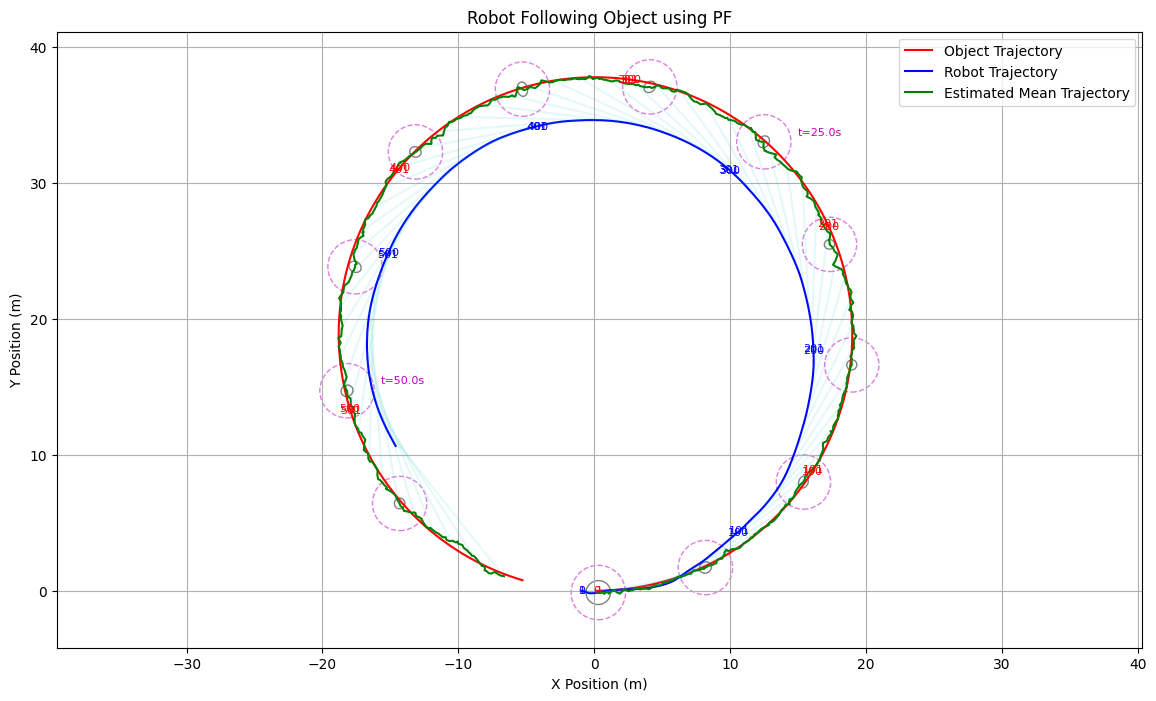

In [ ]:
simulation = RobotFollowerSimulation()
simulation.run_simulation()
simulation.plot_results()